Ayse Dogan 
- April 14, 2025
- Read the lab data for domain shifting

In [1]:
import pandas as pd
import time
#import cudf
import pickle
import matplotlib.pyplot as plt
from matplotlib import figure
import numpy as np
#import cupy as cp
from scipy.io import wavfile
#from scipy import signal, stats
import wfdb
import wfdb.processing
from wfdb.processing import gqrs_detect
import pyhrv.time_domain as td
import warnings
import csv
import os, statistics
from datetime import datetime
#import heartpy as hp
import json
import heartpy as hp

from sklearn.decomposition import FastICA, PCA
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score


import math
from scipy import interpolate
from scipy.signal import find_peaks
from scipy.fftpack import fft
from scipy.signal import welch
from scipy.interpolate import interp1d
from torch.nn.utils.rnn import pad_sequence
from datetime import datetime
# import neurokit2 as nk
import os
import random
import torch
import neurokit2 as nk
from scipy.stats.mstats import winsorize
import warnings
def fix_randomness_seed(SEED):
    #  Set seed for Python's built-in random module
    random.seed(SEED)
    #  Set seed for NumPy
    np.random.seed(SEED)
    #  Set seed for PyTorch (CPU)
    torch.manual_seed(SEED)
    #    Set seed for PyTorch (GPU)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups
    #    Ensure deterministic operations for cuDNN (important for CNNs/RNNs)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {SEED} for full reproducibility.")

In [2]:
data1 = 'TEMP'
data2 = 'EDA'
data3 = 'BVP'
SEED = 42  # Set to any fixed number
fix_randomness_seed(SEED)

Random seed set to 42 for full reproducibility.


In [3]:
# Start timing
start_time = time.time()
now = datetime.now()
# Format the date and time
formatted_now = now.strftime("%Y-%m-%d %H:%M:%S")
print("Formatted date and time:", formatted_now)

Formatted date and time: 2025-06-30 10:59:29


In [4]:

def load_large_pickle(file_path):
    """Lazy loading of pickle files to avoid memory spikes."""
    with open(file_path, 'rb') as f:
        while True:
            try:
                yield pickle.load(f)  # Load one object at a time
            except EOFError:
                break
def load_lab_dataset(data_type):
    """
    Load TEMP or EDA dataset and return the processed features and labels.
    """
    path = lab_data_path
    split_dict_path = os.path.join(path, f"duration_for_data_{data_type}.pkl")

    # Load data
    split_generator = load_large_pickle(split_dict_path)


    split_dict = next(split_generator)

    return split_dict #, train_keys, val_keys, test_keys



#lab_data_path = '/Users/adogan/Library/CloudStorage/Box-Box/UIUC/Notability/Research/LSTM/lab_data/'

lab_data_path = '/Users/adogan/Library/CloudStorage/Box-Box/UIUC/Notability/Research/LSTM/lab_duration_datasets/'
data_name ='tsst'
tsst = load_lab_dataset(data_name)
data_name ='meditation'
meditation = load_lab_dataset(data_name)




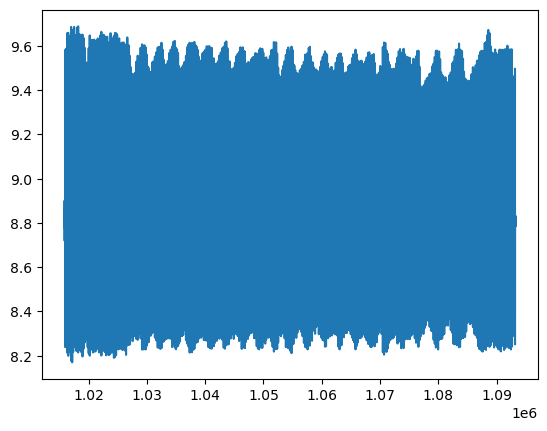

In [5]:
meditation['223'].keys()
fs = 256
ecg_data = meditation['223']['ECG']['ECG']
plt.plot(ecg_data)

In [6]:
# def data_gathering(data, plotting = False):
#     df = pd.DataFrame()
#     padlen = 9
#     for participant in list(data.keys()):
#         print(participant)
#         ecg_data1 = data[participant]['ECG']
                
        
#         if len(ecg_data1) <= padlen:
#             print('padlen: ', participant)
#             print(f"Skipping too-short segment: {participant} (len={len(ecg_data1['ECG'])})")
#             continue
#                         # 2) try to remove baseline wander, skip if it still fails
#         try:
#             ecg_data = hp.filtering.remove_baseline_wander(ecg_data1['ECG'], sample_rate=fs)
#             #ecg_data = hp.filtering.remove_baseline_wander(ecg_data, sample_rate=fs)
#         except ValueError as e:
#             print(f"Baseline removal failed for {participant}: {e}")
#             continue

#         ecg_cleaned = nk.ecg_clean(ecg_data, sampling_rate=fs)

#         ecg_bp = nk.signal_filter(
#             ecg_cleaned,
#             sampling_rate=fs,
#             lowcut=5,
#             highcut=20, #40,
#             method="butterworth", order=4 #3
#         )

#         peaks = wfdb.processing.xqrs_detect(ecg_bp, fs=fs, verbose=False)


#         rpeaks_corrected = wfdb.processing.correct_peaks(
#             ecg_bp, peaks, search_radius=36, smooth_window_size=50, peak_dir="up"
#         )
        
#         marks = np.zeros(len(ecg_bp), dtype=int)
#         marks[rpeaks_corrected] = 1
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore", category=RuntimeWarning)
#             hrv = nk.hrv_time(marks, sampling_rate=fs, show=False)
#         if plotting:
#             plt.figure(figsize=(30,4))
#             plt.plot(ecg_bp, label ='ecg_interp')
#             plt.plot(ecg_bp, label ='ecg_dp')
#             plt.scatter(rpeaks_corrected, ecg_bp[rpeaks_corrected], c="red", label="R-peaks")
#             plt.legend()
#             plt.show()
#         df[participant] = hrv.values[0]
#     df = df.T
#     df.columns = hrv.columns
#     df['ID'] = df.index
#     df.index = list(range(df.shape[0]))
#     df = df.dropna(axis=1)
#     return(df)


# tsst_df = data_gathering(tsst) #convert_signal_records_to_tabular_data(tsst)
# meditation_df = data_gathering(meditation) #convert_signal_records_to_tabular_data(meditation, label=0)

# lab_data_df = pd.concat(
#     [tsst_df.assign(label=0), meditation_df.assign(label=1)],
#     join="inner",            # keep only columns common to both
#     ignore_index=True
# )
# cols = ['ID', 'label'] + [c for c in lab_data_df.columns if c not in ('ID','label')]
# lab_data_df = lab_data_df[cols]
# lab_data_df.head()

In [ ]:
def data_gathering(data, plotting = False):
    df = pd.DataFrame()
    padlen = 9
    rmssd_max = 200  # ms
    nn_min = 200 #ms
    for participant in list(data.keys()):
        print(participant)
        ecg_data1 = data[participant]['ECG']
                
        
        if len(ecg_data1) <= padlen:
            print('padlen: ', participant)
            print(f"Skipping too-short segment: {participant} (len={len(ecg_data1['ECG'])})")
            continue
                        # 2) try to remove baseline wander, skip if it still fails
        try:
            ecg_data = hp.filtering.remove_baseline_wander(ecg_data1['ECG'], sample_rate=fs)
            #ecg_data = hp.filtering.remove_baseline_wander(ecg_data, sample_rate=fs)
        except ValueError as e:
            print(f"Baseline removal failed for {participant}: {e}")
            continue

        ecg_cleaned = nk.ecg_clean(ecg_data, sampling_rate=fs)

        ecg_bp = nk.signal_filter(
            ecg_cleaned,
            sampling_rate=fs,
            lowcut=5,
            highcut=20, #40,
            method="butterworth", order=4 #3
        )

        peaks = wfdb.processing.xqrs_detect(ecg_bp, fs=fs, verbose=False)


        rpeaks_corrected = wfdb.processing.correct_peaks(
            ecg_bp, peaks, search_radius=36, smooth_window_size=50, peak_dir="up"
        )
        
        marks = np.zeros(len(ecg_bp), dtype=int)
        marks[rpeaks_corrected] = 1
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            hrv = nk.hrv_time(marks, sampling_rate=fs, show=False)
        if hrv["HRV_RMSSD"].iloc[0]< rmssd_max and hrv["HRV_MinNN"].iloc[0] > nn_min: 
            df[participant] = hrv.values[0]
        if plotting:
            plt.figure(figsize=(30,4))
            plt.plot(ecg_bp, label ='ecg_interp')
            plt.plot(ecg_bp, label ='ecg_dp')
            plt.scatter(rpeaks_corrected, ecg_bp[rpeaks_corrected], c="red", label="R-peaks")
            plt.legend()
            plt.show()
    df = df.T
    df.columns = hrv.columns
    df['ID'] = df.index
    df.index = list(range(df.shape[0]))
    df = df.dropna(axis=1)
    return(df)
tsst_df = data_gathering(tsst) #convert_signal_records_to_tabular_data(tsst)
meditation_df = data_gathering(meditation) #convert_signal_records_to_tabular_data(meditation, label=0)

lab_data_df = pd.concat(
    [tsst_df.assign(label=0), meditation_df.assign(label=1)],
    join="inner",            # keep only columns common to both
    ignore_index=True
)
cols = ['ID', 'label'] + [c for c in lab_data_df.columns if c not in ('ID','label')]
lab_data_df = lab_data_df[cols]
print('len(lab_data_df.ID.unique()): ', len(lab_data_df.ID.unique()))
lab_data_df.head()

184
88
277
287
194
90
269
271
244
267
222
33
10
47
284
272
268
29
294
219
8
283
290
292
289
30
216
252
253
278
264
71
9
270
5
291
221
282
15
padlen:  15
Skipping too-short segment: 15 (len=0)
276
286
38
39
295
223
13
249
18
92
184
88
277
287
194
90
269
271
244
267
222
33
10
47
284
272
268
29
294
219
8
283
290
292
289
30
216
252
253
278
264
71
9
270
5
291
221
282
15
padlen:  15
Skipping too-short segment: 15 (len=0)
276
286
38
39
295
223
13
249
18
92
len(lab_data_df.ID.unique()):  45


,ID,label,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,...,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN
0,184,0,748.922831,102.774074,77.554303,71.337130,53.706134,53.726958,0.137229,0.071711,...,140.625000,1.913638,664.06250,835.93750,26.336174,58.326878,554.68750,1097.65625,19.861538,289.0625
1,88,0,902.894193,75.067521,35.974418,65.687712,45.903571,45.925891,0.083141,0.050840,...,101.562500,1.635331,835.93750,964.84375,23.517979,55.685131,656.25000,1074.21875,19.055556,382.8125
2,277,0,725.225636,127.110093,106.715634,70.969096,59.222491,59.246942,0.175270,0.081661,...,187.500000,2.146315,609.37500,835.93750,32.053422,55.843072,476.56250,1054.68750,33.277778,187.5000
3,287,0,1010.527301,136.359821,92.901512,98.164227,111.772706,111.833463,0.134939,0.110608,...,182.617188,1.219974,898.43750,1121.09375,59.259259,80.065359,300.78125,1398.43750,32.785714,679.6875
4,194,0,718.108574,58.649200,36.582470,45.463078,26.798227,26.809886,0.081672,0.037318,...,85.937500,2.188548,667.96875,769.53125,6.168549,35.794961,574.21875,914.06250,14.948052,257.8125


# Read the Wild Data

In [9]:

def load_large_pickle(file_path):
    """Lazy loading of pickle files to avoid memory spikes."""
    with open(file_path, 'rb') as f:
        while True:
            try:
                yield pickle.load(f)  # Load one object at a time
            except EOFError:
                break

def load_dataset(duration_min: int = 30,
                 base_dir: str = None):
    """
    Load and merge split + label dictionaries from chunked pickles.

    Parameters
    ----------
    duration_min : int
        The duration (in minutes) used in the filename, e.g. 30 → all_split_ECG_dict_30_min.pkl
    base_dir : str, optional
        Directory containing the pickle files.  If None, uses os.getcwd().

    Returns
    -------
    split_dict : dict
        Merged dictionary from all split‐chunks.
    label_dict : dict
        Merged dictionary from all label‐chunks.
    """
    # 1. Resolve base directory
    if base_dir is None:
        base_dir = os.getcwd()
    # 2. Build file names
    split_filename = f"all_split_ECG_dict_{duration_min}_min.pkl"
    label_filename = f"all_label_ECG_dict_{duration_min}_min.pkl"
    split_path = os.path.join(base_dir, split_filename)
    label_path = os.path.join(base_dir, label_filename)

    # 3. Merge all chunks from the split pickle
    split_dict = {}
    for chunk in load_large_pickle(split_path):
        if not isinstance(chunk, dict):
            raise ValueError(f"Expected dict from load_large_pickle, got {type(chunk)}")
        split_dict.update(chunk)

    # 4. Merge all chunks from the label pickle
    label_dict = {}
    for chunk in load_large_pickle(label_path):
        if not isinstance(chunk, dict):
            raise ValueError(f"Expected dict from load_large_pickle, got {type(chunk)}")
        label_dict.update(chunk)

    return split_dict, label_dict

split_dict_temp, label_dict_temp = load_dataset()
print("Participants:", split_dict_temp.keys())
records = []
for p, days in split_dict_temp.items():
    for d, slices in days.items():
        for st, ecg in slices.items():
            records.append((p, d, int(st), ecg.T.values[0]))

df = pd.DataFrame(records, columns=["participant", "day", "start", "ecg"])
df.head()

Participants: dict_keys([1, 29, 9, 216, 33, 2, 262, 222, 5, 221, 15, 92, 88, 13, 223, 24, 253, 71, 39, 8, 90, 219, 244, 249])


,participant,day,start,ecg
0,1,day0_hex,1680614636,"[13.472000000000001, 0.0064, 0.0, 0.0064, 0.0,..."
1,1,day0_hex,1680616436,"[8.6464, 8.716800000000001, 8.8, 8.8832, 8.972..."
2,1,day0_hex,1680618236,"[8.716800000000001, 8.704, 8.7104, 8.716800000..."
3,1,day0_hex,1680620036,"[8.7424, 8.7552, 8.7616, 8.7744, 8.7744, 8.787..."
4,1,day0_hex,1680621836,"[8.704, 8.704, 8.704, 8.704, 8.7104, 8.7104, 8..."


In [10]:
data = split_dict_temp
plotting = True
tranformed_dict = {}
padlen = 9  # filtfilt needs > padlen points
clip_val = 1.0

win_sec    = 10                   # window length
step_sec   = 10                   # non‑overlap; set <win_sec for overlap

win_len    = int(win_sec  * fs)
step_len   = int(step_sec * fs)            


def keep_window(seg, fs,
                amp_thresh=1.0,     # a.u. for your filtered trace
                sd_thresh=0.5, z=6,  max_outliers=2,  hr_lo=30,hr_hi=220):
    zscores = np.abs((seg - seg.mean()) / seg.std(ddof=0))
    if np.sum(zscores > z) > max_outliers:
        qual = False
        return qual

    if np.ptp(seg) > amp_thresh:# or np.std(seg) > sd_thresh:
        qual = False
        return qual
    # 3) But also the *noise floor* must be low: enforce a std‐dev cap
    if np.std(seg, ddof=0) > sd_thresh:
        return False
    peaks, info = nk.ecg_peaks(seg, sampling_rate=fs)
    
    # sum_peaks = peaks.sum()  
    if peaks['ECG_R_Peaks'].sum()  <3:
        #print(sum_peaks)
        qual = False
        return qual
    
        # compute instantaneous HR (bpm)
    n_peaks = peaks["ECG_R_Peaks"].sum()
    duration_s = len(seg) / fs
    hr = n_peaks / duration_s * 60
    if not (hr_lo <= hr <= hr_hi):
        return False

    # 2) standard Zhao‑2018 fuzzy QC
    qual = nk.ecg_quality(seg, sampling_rate=fs,
                          method="zhao2018", approach="fuzzy")
    return qual 

def transform_ecg(ecg_data1, info, plotting = False): 
    participant = int(info[0])
    day = info[1]
    #print(participant,day)
    start_time = int(info[-1])           
    if len(ecg_data1) <= padlen:
        #print(f"Skipping too-short segment: {participant} {day} {start_time} (len={len(ecg_data1)})")
        return False
    else:
                    # 2) try to remove baseline wander, skip if it still fails
        ecg_data = hp.filtering.remove_baseline_wander(ecg_data1, sample_rate=fs)
        quality_check = nk.ecg_quality(ecg_data, sampling_rate=fs, method="zhao2018", approach="fuzzy")

        if quality_check == 'Excellent':
            ecg_interp = nk.signal_filter(
                ecg_data,
                sampling_rate=fs,
                lowcut=5,
                highcut=20, #35, #40,
                method="butterworth", order=4 #3
            )
            starts = np.arange(0, len(ecg_interp) - win_len + 1, step_len)
            cleaned       = ecg_interp.copy()
            good          = np.ones(len(starts), dtype=bool)
            for i, s in enumerate(starts):
                seg              = cleaned[s : s + win_len]          # 5‑s slice
                ok       = keep_window(seg, fs) 
                good[i]          = ok

                if ok!= 'Excellent':  
                    cleaned[s : s + win_len] = np.nan                # or 0.0
            ecg_interp = cleaned[~np.isnan(cleaned)] 
            if len(ecg_interp)>0:
                peaks = wfdb.processing.xqrs_detect(ecg_interp, fs=fs, verbose=False)
                rpeaks_corrected = wfdb.processing.correct_peaks(
                    ecg_interp, peaks, search_radius=36, smooth_window_size=50, peak_dir="up"
                )
                rpeaks_corrected = np.unique(rpeaks_corrected)
                if len(rpeaks_corrected)>=30:                   
                    marks = np.zeros(len(ecg_interp), dtype=int)
                    marks[rpeaks_corrected] = 1
                    if plotting:
                        print(plotting)
                        measure = 1000#len(ecg_interp) #7000                     # first 1000 samples ≈ 4 s if fs = 256
                        start   = 0                        # set >0 to zoom later in the segment
                        s, e = start, start + measure      # slice indices
                        x    = np.arange(s, e) / fs        # x‑axis in seconds; drop “/fs” if you prefer samples
                        # mask R‑peaks that fall inside the window
                        in_window = (rpeaks_corrected >= s) & (rpeaks_corrected < e)
                        r_local   = rpeaks_corrected[in_window]
                        x_peaks   = r_local / fs           # seconds; use r_local for samples

                        plt.figure(figsize=(15, 4))
                        #plt.plot(x, ecg_bp[s:e],     lw=0.7, label='ecg_bp (clipped)',   color='steelblue')
                        plt.plot(x, ecg_interp[s:e], lw=0.7, label='ecg_interp (spline)',color='orange')
                        plt.scatter(x_peaks, ecg_interp[r_local], c='red', s=18, label='R‑peaks')

                        plt.xlabel('Time (s)')
                        plt.ylabel('Amplitude (a.u.)')
                        plt.title(f'ECG segment: samples {s}-{e}')
                        plt.legend(loc='upper right')
                        plt.tight_layout()
                        plt.show()

                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        hrv = nk.hrv_time(marks, sampling_rate=fs, show=False)
                else:
                    #print('Cleaned signal does not have enough peak for participant:',participant, day, 'start_time: ', start_time)
                    return False


            else:
                
                #print('Cleaned signal is too small for participant:',participant, day, 'start_time: ', start_time)
                return False

        else:
            #print(f"Quality check: {participant} {day} {start_time} {quality_check}")
            return False
        return(hrv)
    
    
rmssd_max = 200  # ms
nn_min = 200 #ms
wild_data_df =pd.DataFrame()
for row in range(df.shape[0]): #range(10): range(df.shape[0]): #range(10): #
    selected_info = df.loc[row, df.columns[:3]].to_frame().T #df.loc[0,df.columns[:3]]
    info = selected_info.values[0]
    #print(info)
    ecg = df.loc[row,'ecg']
    hrv = transform_ecg(ecg, info, plotting = False)
    #print(hrv)
    if hrv is not False and not hrv.empty: #hrv !=False:
        if hrv["HRV_RMSSD"].iloc[0]< rmssd_max and hrv["HRV_MinNN"].iloc[0] > nn_min:    # extract the single-value
            combined = pd.concat([selected_info.reset_index(drop=True),
                                hrv.reset_index(drop=True)],
                                axis=1)
            # 4) append to your growing DataFrame
            wild_data_df = pd.concat([wild_data_df, combined],
                                    ignore_index=True)

(array([5., 8., 4., 6., 8., 8., 3., 2., 2., 4.]),
 array([ 49.60799732,  59.95819498,  70.30839263,  80.65859029,
         91.00878795, 101.3589856 , 111.70918326, 122.05938091,
        132.40957857, 142.75977623, 153.10997388]),
 <BarContainer object of 10 artists>)

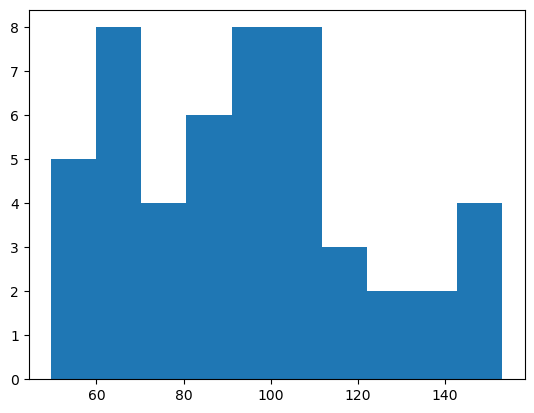

In [96]:
#plt.hist(wild_data_df['HRV_SDNN'])
plt.hist(lab_data_df['HRV_SDNN'])

(array([ 70., 330., 474., 369., 219., 108.,  41.,  17.,   8.,   2.]),
 array([ 21.72875932,  43.36930673,  65.00985413,  86.65040153,
        108.29094893, 129.93149633, 151.57204374, 173.21259114,
        194.85313854, 216.49368594, 238.13423334]),
 <BarContainer object of 10 artists>)

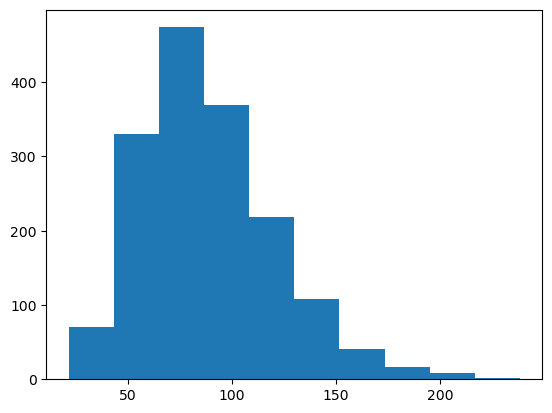

In [97]:
plt.hist(wild_data_df['HRV_SDNN'])

DataFrame – Contains time domain HRV metrics:

MeanNN: The mean of the RR intervals.

SDNN: The standard deviation of the RR intervals.

SDANN1, SDANN2, SDANN5: The standard deviation of average RR intervals extracted from n-minute segments of time series data (1, 2 and 5 by default). Note that these indices require a minimal duration of signal to be computed (3, 6 and 15 minutes respectively) and will be silently skipped if the data provided is too short.

SDNNI1, SDNNI2, SDNNI5: The mean of the standard deviations of RR intervals extracted from n-minute segments of time series data (1, 2 and 5 by default). Note that these indices require a minimal duration of signal to be computed (3, 6 and 15 minutes respectively) and will be silently skipped if the data provided is too short.

RMSSD: The square root of the mean of the squared successive differences between adjacent RR intervals. It is equivalent (although on another scale) to SD1, and therefore it is redundant to report correlations with both (Ciccone, 2017).

SDSD: The standard deviation of the successive differences between RR intervals.

CVNN: The standard deviation of the RR intervals (SDNN) divided by the mean of the RR intervals (MeanNN).

CVSD: The root mean square of successive differences (RMSSD) divided by the mean of the RR intervals (MeanNN).

MedianNN: The median of the RR intervals.

MadNN: The median absolute deviation of the RR intervals.

MCVNN: The median absolute deviation of the RR intervals (MadNN) divided by the median of the RR intervals (MedianNN).

IQRNN: The interquartile range (IQR) of the RR intervals.

SDRMSSD: SDNN / RMSSD, a time-domain equivalent for the low Frequency-to-High Frequency (LF/HF) Ratio (Sollers et al., 2007).

Prc20NN: The 20th percentile of the RR intervals (Han, 2017; Hovsepian, 2015).

Prc80NN: The 80th percentile of the RR intervals (Han, 2017; Hovsepian, 2015).

pNN50: The percentage of absolute differences in successive RR intervals greater than 50 ms (Bigger et al., 1988; Mietus et al., 2002).

pNN20: The percentage of absolute differences in successive RR intervals greater than 20 ms (Mietus et al., 2002).

MinNN: The minimum of the RR intervals (Parent, 2019; Subramaniam, 2022).

MaxNN: The maximum of the RR intervals (Parent, 2019; Subramaniam, 2022).

TINN: A geometrical parameter of the HRV, or more specifically, the baseline width of the RR intervals distribution obtained by triangular interpolation, where the error of least squares determines the triangle. It is an approximation of the RR interval distribution.

HTI: The HRV triangular index, measuring the total number of RR intervals divided by the height of the RR intervals histogram.

In [98]:
wild_data_df.isna().sum()

participant       0
day               0
start             0
HRV_MeanNN        0
HRV_SDNN          0
HRV_SDANN1       50
HRV_SDNNI1       50
HRV_SDANN2       76
HRV_SDNNI2       76
HRV_SDANN5      129
HRV_SDNNI5      129
HRV_RMSSD         0
HRV_SDSD          0
HRV_CVNN          0
HRV_CVSD          0
HRV_MedianNN      0
HRV_MadNN         0
HRV_MCVNN         0
HRV_IQRNN         0
HRV_SDRMSSD       0
HRV_Prc20NN       0
HRV_Prc80NN       0
HRV_pNN50         0
HRV_pNN20         0
HRV_MinNN         0
HRV_MaxNN         0
HRV_HTI           0
HRV_TINN          0
dtype: int64

In [99]:
lab_data_df.isna().sum()

ID              0
label           0
HRV_MeanNN      0
HRV_SDNN        0
HRV_SDANN1      0
HRV_SDNNI1      0
HRV_RMSSD       0
HRV_SDSD        0
HRV_CVNN        0
HRV_CVSD        0
HRV_MedianNN    0
HRV_MadNN       0
HRV_MCVNN       0
HRV_IQRNN       0
HRV_SDRMSSD     0
HRV_Prc20NN     0
HRV_Prc80NN     0
HRV_pNN50       0
HRV_pNN20       0
HRV_MinNN       0
HRV_MaxNN       0
HRV_HTI         0
HRV_TINN        0
dtype: int64

In [ ]:
wild_data_df[wild_data_df['ID'] == 249][wild_data_df['day']=='day5_hex']

/var/folders/sk/4n577_gn46nf235m3zk4dr9c0000gn/T/ipykernel_48135/477240190.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wild_data_df[wild_data_df['ID'] == 249][wild_data_df['day']=='day5_hex']


,ID,day,time,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,...,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,label
3644,249,day5_hex,1.711898e+09,871.780750,128.660556,106.306450,71.003314,101.989005,79.429800,90.889877,...,1.495712,765.62500,992.18750,56.104651,79.166667,496.09375,1187.50000,34.983051,679.6875,0
3645,249,day5_hex,1.711900e+09,896.188683,112.247182,80.691392,74.848834,74.746915,80.894472,61.909694,...,1.227616,798.43750,992.18750,59.213147,80.229084,531.25000,1179.68750,29.101449,601.5625,0
3646,249,day5_hex,1.711902e+09,961.526256,91.894424,52.129929,75.117782,49.463066,77.459761,36.614522,...,0.981064,882.81250,1039.06250,61.304115,82.576162,656.25000,1195.31250,24.298701,453.1250,1
3647,249,day5_hex,1.711904e+09,970.796934,79.133035,36.528394,69.965366,30.875670,72.403771,23.889890,...,0.829781,906.25000,1039.06250,61.737723,81.921209,714.84375,1300.78125,23.162500,429.6875,0
3648,249,day5_hex,1.711905e+09,951.870453,86.711731,45.631091,73.599275,43.794898,75.440499,40.007645,...,0.885750,878.90625,1027.34375,61.693122,82.539683,468.75000,1226.56250,24.868421,0.0000,0
3649,249,day5_hex,1.711907e+09,825.586565,125.287354,103.871065,71.014465,103.239975,74.236957,102.190356,...,1.493797,707.03125,945.31250,56.310234,80.128499,339.84375,1148.43750,37.568966,0.0000,0
3650,249,day5_hex,1.711909e+09,758.217446,100.593748,68.817352,74.006810,63.332875,80.332623,55.764849,...,1.351038,679.68750,832.03125,54.024442,80.151707,320.31250,1148.43750,24.463918,0.0000,0
3651,249,day5_hex,1.711911e+09,822.873184,98.889051,77.208436,66.323601,73.062325,71.130826,70.997244,...,1.413166,738.28125,910.15625,52.836231,79.139982,542.96875,1160.15625,27.325000,476.5625,0
3652,249,day5_hex,1.711913e+09,862.122109,91.976001,57.714664,70.011025,54.133624,74.144537,54.404833,...,1.230484,789.06250,945.31250,53.211889,79.721956,562.50000,1148.43750,24.255814,476.5625,0
3653,249,day5_hex,1.711914e+09,919.508484,79.463591,31.443005,72.526572,24.632517,75.260258,17.520654,...,1.035325,855.46875,988.28125,53.016360,77.709611,617.18750,1156.25000,22.482759,460.9375,1


In [ ]:
wild_data_df.iloc[:,3:].describe()

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,label
count,3554.000000,3554.000000,3554.000000,3554.000000,3554.000000,3554.000000,3.554000e+03,3554.000000,3554.000000,3554.000000,...,3554.000000,3554.000000,3554.000000,3554.000000,3554.000000,3554.000000,3.554000e+03,3554.000000,3554.00000,3554.000000
mean,971.451378,1773.294936,3227.133885,1248.117405,3816.896899,1609.695281,3.520957e+03,2486.796556,2256.975178,2263.363416,...,1.141773,622.112628,853.747318,54.985636,76.901555,371.789489,2.790230e+04,25.553191,193.86167,0.068374
std,1686.805782,8824.388194,20500.859499,7949.130714,27764.758603,9822.441267,2.938386e+04,15283.510703,11797.002564,11861.001295,...,0.369366,120.738710,530.205713,13.135348,9.388889,95.368090,1.129192e+05,7.219072,236.15122,0.252422
min,401.368495,33.789920,8.945449,21.992173,6.377608,25.278154,2.049862e+00,27.893998,27.529528,27.532990,...,0.615652,308.593750,453.125000,10.231272,20.297177,253.906250,5.898438e+02,8.720000,0.00000,0.000000
25%,639.995150,78.432138,37.146890,62.732093,30.806968,65.926909,2.337810e+01,69.903773,73.207359,73.223775,...,0.883501,542.968750,710.937500,47.803429,73.932582,300.781250,9.921875e+02,20.634488,0.00000,0.000000
50%,723.357442,96.358235,55.438616,73.959156,49.532250,77.825622,4.135506e+01,83.401631,87.583118,87.598536,...,1.056451,621.093750,796.875000,56.935773,79.243265,339.843750,1.121094e+03,24.386980,0.00000,0.000000
75%,822.053367,127.589193,86.640468,91.296363,81.418968,96.882562,7.370747e+01,104.460024,101.299516,101.317825,...,1.290061,699.218750,898.437500,63.348038,82.202674,440.429688,1.288086e+03,29.279515,406.25000,0.000000
max,36133.370536,138531.824824,473613.954299,231450.555997,876803.692282,306736.565874,1.073951e+06,448148.956536,197593.992499,198980.634018,...,3.392746,1039.062500,21992.187500,97.872340,99.019608,738.281250,1.519801e+06,77.125000,1031.25000,1.000000


In [ ]:
lab_data_df.iloc[:,2:].describe()

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN
count,50.000000,50.000000,50.000000,50.000000,48.000000,48.000000,25.000000,25.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,800.074689,98.053262,43.592276,84.673426,39.570708,86.409360,44.960603,88.058229,75.999629,76.070217,...,136.582031,1.314508,714.625000,883.109375,43.931103,70.384233,509.843750,1116.484375,21.766643,302.343750
std,113.506201,25.674784,26.912827,22.920369,26.990466,20.410664,27.578324,21.152287,20.426771,20.464324,...,43.997768,0.289274,102.688645,127.265806,10.191405,9.218190,123.047166,151.850716,6.391394,156.483005
min,564.296305,55.079909,8.611556,46.836031,5.178501,55.981842,1.898026,62.122029,44.605069,44.644103,...,63.476562,0.951187,511.718750,605.468750,18.613139,39.416058,312.500000,777.343750,11.051282,0.000000
25%,729.807243,76.198513,22.430959,67.629229,18.996514,69.823757,23.590311,72.332781,61.213243,61.250837,...,98.632812,1.106642,652.343750,795.117188,36.749359,67.748838,423.828125,1024.414062,18.090944,183.593750
50%,801.610436,96.827347,35.008411,81.623513,30.112204,83.802884,39.913661,83.975619,73.320952,73.379293,...,132.324219,1.285743,698.828125,878.906250,44.140834,72.028953,515.625000,1089.843750,20.807937,312.500000
75%,874.675912,113.166090,60.027024,99.434609,52.904065,99.489518,64.490248,100.390692,84.331349,84.447145,...,157.958984,1.444905,771.484375,962.304688,49.037480,76.098907,602.539062,1184.570312,24.755405,406.250000
max,1102.893201,155.396725,107.727031,148.120026,107.338106,142.621815,104.443624,140.233246,158.199686,158.447886,...,250.000000,2.354190,1007.812500,1183.593750,69.687500,87.500000,820.312500,1496.093750,45.458333,703.125000


In [ ]:
# wild_data_df.to_csv("wild_data_df.csv")#, index=False)
# lab_data_df.to_csv("lab_data_df.csv")#, index=False)
wild_data_df.to_csv("wild_data_df_neurokit_30min.csv", index=False)
lab_data_df.to_csv("lab_data_df_neurokit_30min.csv", index=False)


In [ ]:
'''SAVE the LABELS'''
records = []
for p, days in label_dict_temp.items():
    for d, slices in days.items():
        for st, ecg in slices.items():
            records.append((p, d, int(st), ecg))

df = pd.DataFrame(records, columns=["participant", "day", "start", "label"])
df.head()
df.to_csv("wild_data_df_neurokit_30min_beforeAddingNewParticipants_LABELS.csv", index=False)


In [ ]:

def load_large_pickle(file_path):
    """Lazy loading of pickle files to avoid memory spikes."""
    with open(file_path, 'rb') as f:
        while True:
            try:
                yield pickle.load(f)  # Load one object at a time
            except EOFError:
                break

def load_dataset(duration_min: int = 30,
                 base_dir: str = None):
    """
    Load and merge split + label dictionaries from chunked pickles.

    Parameters
    ----------
    duration_min : int
        The duration (in minutes) used in the filename, e.g. 30 → all_split_ECG_dict_30_min.pkl
    base_dir : str, optional
        Directory containing the pickle files.  If None, uses os.getcwd().

    Returns
    -------
    split_dict : dict
        Merged dictionary from all split‐chunks.
    label_dict : dict
        Merged dictionary from all label‐chunks.
    """
    # 1. Resolve base directory
    if base_dir is None:
        base_dir = os.getcwd()
    # 2. Build file names
    split_filename = f"all_split_ECG_dict_{duration_min}_min.pkl"
    label_filename = f"all_label_ECG_dict_{duration_min}_min.pkl"
    split_path = os.path.join(base_dir, split_filename)
    label_path = os.path.join(base_dir, label_filename)

    # 3. Merge all chunks from the split pickle
    split_dict = {}
    for chunk in load_large_pickle(split_path):
        if not isinstance(chunk, dict):
            raise ValueError(f"Expected dict from load_large_pickle, got {type(chunk)}")
        split_dict.update(chunk)

    # 4. Merge all chunks from the label pickle
    label_dict = {}
    for chunk in load_large_pickle(label_path):
        if not isinstance(chunk, dict):
            raise ValueError(f"Expected dict from load_large_pickle, got {type(chunk)}")
        label_dict.update(chunk)

    return split_dict, label_dict

split_dict_temp, label_dict_temp = load_dataset()
print("Participants:", split_dict_temp.keys())
records = []
for p, days in label_dict_temp.items():
    for d, slices in days.items():
        for st, ecg in slices.items():
            records.append((p, d, int(st), ecg))

df = pd.DataFrame(records, columns=["participant", "day", "start", "label"])
df.head()
df.to_csv("wild_data_df_neurokit_30min_beforeAddingNewParticipants_LABELS.csv", index=False)
